In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from datetime import timedelta
import pickle

In [6]:
nyc_data = pd.read_csv("nyc_data.csv", parse_dates=['date'])
# nyc_data['county'] = "NYC"
tulsa_data = pd.read_csv("tulsa_data.csv", parse_dates=['date'])
# tulsa_data['county'] = "Tulsa"
la_data = pd.read_csv("la_data.csv", parse_dates=['date'])
# la_data['county'] = "LA"

In [7]:
frames = [nyc_data, la_data, tulsa_data]
combined_data = pd.concat(frames).fillna(0)
combined_data

,date,cases,deaths,deaths_normalized,cases_normalized,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,...,apple_driving,apple_transit,apple_walking,maskScore,mask_never,mask_rarely,mask_sometimes,mask_frequently,mask_always,PSScore
0,2020-03-01,1,0,0.000000,0.000012,23.0,9.0,33.0,5.0,10.0,...,99.76,84.89,102.44,9.06,0.044,0.028,0.051,0.066,0.812,0.580398
1,2020-03-02,1,0,0.000000,0.000012,14.0,7.0,40.0,3.0,9.0,...,96.30,87.22,100.47,9.06,0.044,0.028,0.051,0.066,0.812,0.580398
2,2020-03-03,2,0,0.000000,0.000024,14.0,9.0,36.0,6.0,5.0,...,98.74,90.22,97.39,9.06,0.044,0.028,0.051,0.066,0.812,0.580398
3,2020-03-04,2,0,0.000000,0.000024,11.0,8.0,7.0,12.0,4.0,...,103.39,94.39,108.45,9.06,0.044,0.028,0.051,0.066,0.812,0.580398
4,2020-03-05,4,0,0.000000,0.000048,13.0,11.0,48.0,12.0,1.0,...,110.85,99.33,115.85,9.06,0.044,0.028,0.051,0.066,0.812,0.580398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2020-11-04,23351,219,0.054588,5.820434,-8.0,-5.0,34.0,-12.0,-24.0,...,112.03,0.00,133.88,7.41,0.074,0.061,0.141,0.243,0.482,-0.165644
244,2020-11-05,23656,221,0.055086,5.896458,-9.0,0.0,29.0,-7.0,-24.0,...,120.54,0.00,153.90,7.41,0.074,0.061,0.141,0.243,0.482,-0.165644
245,2020-11-06,23983,225,0.056083,5.977966,-10.0,-6.0,43.0,-12.0,-25.0,...,141.30,0.00,182.19,7.41,0.074,0.061,0.141,0.243,0.482,-0.165644
246,2020-11-07,24361,226,0.056332,6.072185,-15.0,-5.0,25.0,6.0,-8.0,...,135.05,0.00,198.97,7.41,0.074,0.061,0.141,0.243,0.482,-0.165644


In [14]:
# utility function to split test and train
def data_split(df, columns, date_range):
    df.drop(df.columns.difference(columns), 1, inplace=True)

    df["date_from_start"] = df["date"] - pd.to_datetime('2020-03-01')
    df["date_from_start"] = df["date_from_start"] / np.timedelta64(1,"D")
    end_train, end_test = date_range
    train = df[(df['date'] < end_train)]
    test = df[(df['date'] >= end_train) & (df['date'] < end_test)]
    
    # print(train.head())
    train_y = train["deaths"]#train.deaths.values
    train_x = train.drop(["deaths", "date"], axis=1)
    test_y = test["deaths"] #test.date.values
    test_x = test.drop(["deaths", "date"], axis=1)

    return train_x, train_y, test_x, test_y

In [15]:
# define date ranges for different periods of the pandemic
date_range_1 = ('2020-05-01', '2020-06-01')
date_range_2 = ('2020-08-01', '2020-09-01')
date_range_3 = ('2020-10-01', '2020-11-01')
date_ranges = [date_range_1, date_range_2, date_range_3]

# define column categories
base_columns = ['deaths', 'date', 'county']
google_maps_columns = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
apple_maps_columns = ['apple_driving', 'apple_transit', 'apple_walking']
mask_score_column = ['maskScore']
mask_breakdown_column = ['mask_never', 'mask_rarely', 'mask_sometimes', 'mask_frequently', 'mask_always']
PSScore_column = ['PSScore']

# define feture column combinations
feature_columns_all = { 
               #  "1": base_columns + PSScore_column + google_maps_columns + mask_score_column,
              #   "2": base_columns + PSScore_column + google_maps_columns + mask_breakdown_column,
              #   "3": base_columns + PSScore_column + apple_maps_columns + mask_score_column,
              #   "4": base_columns + PSScore_column + google_maps_columns + apple_maps_columns + mask_breakdown_column,
                "5": base_columns + PSScore_column + google_maps_columns + apple_maps_columns + mask_score_column,
              #   "6": base_columns + PSScore_column + apple_maps_columns + mask_breakdown_column,
              #   "7": base_columns + PSScore_column + mask_score_column,
              #   "8": base_columns + PSScore_column + mask_breakdown_column,
              #   "9": base_columns + PSScore_column + google_maps_columns,
              #   "10": base_columns + PSScore_column + apple_maps_columns,
}

# define models
models = {"SVM - Linear": SVR(kernel='linear', gamma='auto'),
            "Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators = 10),
            "AdaBoost Regression": AdaBoostRegressor(),
            "Neural Network": MLPRegressor(max_iter=2000),
            }

model_colors = {"SVM - Linear": "#1f77b4",
            "Linear Regression": "#ff7f0e",
            "Random Forest": "#2ca02c",
            "AdaBoost Regression": "#d62728",
            "Neural Network": "#9467bd",
            }

In [16]:
def modelIterations(model, data, columns, daterange):
    # endTrain, endTest = pd.to_datetime(daterange[0]), pd.to_datetime(daterange[1])
    rmse_scores = []
    rmse_percent_scores = []
    predictions = []
    for i in range(4):
        endTrain, endTest = pd.to_datetime(daterange[0]), pd.to_datetime(daterange[1])
        daysToAdd = i * 7
        endTrain = endTrain + timedelta(days=daysToAdd)
        endTest = endTrain + timedelta(days=7)
        daterange_temp = [endTrain, endTest]
        train_x, train_y, test_x, test_y = data_split(data, columns, daterange_temp)

        model.fit(train_x, train_y)
        preds = model.predict(test_x)
        rmse = mean_squared_error(test_y, preds, squared=False)
        
        rmse_scores.append(rmse)
        rmse_percent_scores.append(rmse/ test_y.mean() * 100)
        predictions.append(preds)

    return rmse_scores, rmse_percent_scores, predictions

feature_columns:  ['deaths', 'date', 'county', 'PSScore', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'apple_driving', 'apple_transit', 'apple_walking', 'maskScore']
date_range:  ('2020-05-01', '2020-06-01')
current model:  SVM - Linear
rmse_scores:  [10511.78700133697, 10949.208407798207, 11121.515434329707, 11166.205712532605]
rmse_percent_scores:  [158.76205708167714, 155.0952605099137, 150.46987992199456, 146.1754801318967]
predictions:  [array([352.34937014, 358.75390783, 365.15844551, 371.5629832 ,
       377.96752088, 384.37205857, 390.77659625, 345.40515257,
       351.80969026, 358.21422794, 364.61876562, 371.02330331,
       377.42784099, 383.83237868, 329.22454209, 335.62907977,
       342.03361746, 348.43815514, 354.84269283, 361.24723051,
 

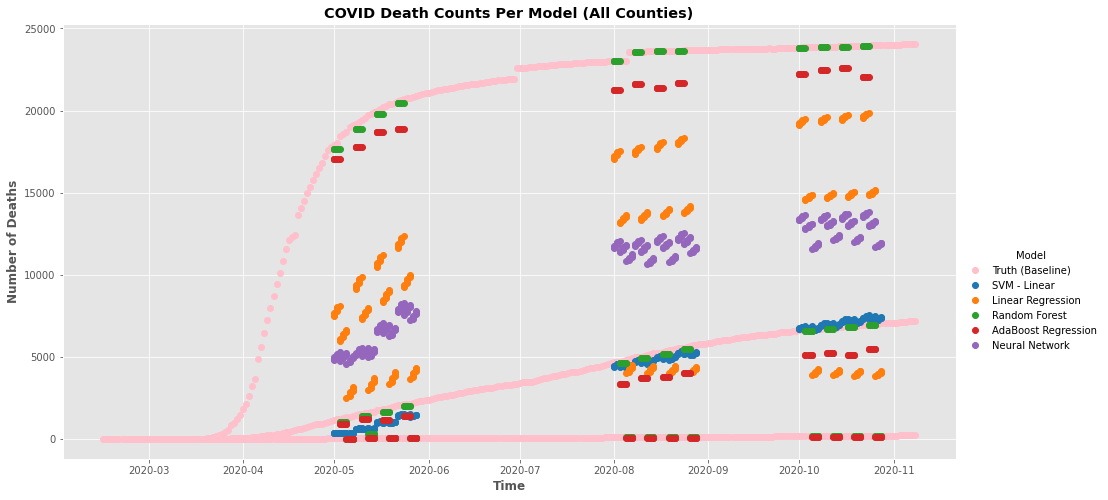

In [17]:
def runs(df, county_name):
    for feature_columns_key in feature_columns_all.keys():
        feature_columns = feature_columns_all[feature_columns_key]
        print("feature_columns: ", feature_columns)
        logging = {}
        logging_features = {}
        logging_rmse = {}
        for date_range in date_ranges:
            print("date_range: ", date_range)
            logging[date_range] = {}
            logging_rmse[date_range] = {}
            logging_features[date_range] = {}
            for modelKey in models.keys():
                print("current model: ", modelKey)
                model = models[modelKey]
                rmse_scores, rmse_percent_scores, predictions = modelIterations(model, df, feature_columns, date_range)
                if modelKey == "Random Forest":
                    logging_features[date_range][modelKey + "_RF_Features"] = {}
                    logging_features[date_range][modelKey + "_RF_Features"]["columns"] = feature_columns
                    logging_features[date_range][modelKey + "_RF_Features"]["feature_importance"] = model.feature_importances_
                if modelKey == "AdaBoost Regression":
                    logging_features[date_range][modelKey + "_ADA_Features"] = {}
                    logging_features[date_range][modelKey + "_ADA_Features"]["columns"] = feature_columns
                    logging_features[date_range][modelKey + "_ADA_Features"]["feature_importance"] = model.feature_importances_

                if modelKey == "Linear Regression":
                    logging_features[date_range][modelKey + "_LR_Features"] = {}
                    logging_features[date_range][modelKey + "_LR_Features"]["columns"] = feature_columns
                    logging_features[date_range][modelKey + "_LR_Features"]["model_coef"] = model.coef_
                    

                print("rmse_scores: ", rmse_scores)
                print("rmse_percent_scores: ", rmse_percent_scores)
                print("predictions: ", predictions)
                logging[date_range][modelKey] = predictions

                logging_rmse[date_range][modelKey] = {}
                logging_rmse[date_range][modelKey]["rmse_scores"] = rmse_scores
                logging_rmse[date_range][modelKey]["rmse_percent_scores"] = rmse_percent_scores
                logging_rmse[date_range][modelKey]["predictions"] = predictions

        pickle.dump(logging, open("outputs_combined/output_" + county_name + "_" + str(feature_columns_key) + ".p", "wb"))
        pickle.dump(logging_rmse, open("outputs_combined/output_rmse_" + county_name + "_" + str(feature_columns_key) + ".p", "wb" ))
        pickle.dump(logging_features, open("outputs_combined/output_features_" + county_name + "_" + str(feature_columns_key) + ".p", "wb" ))

        plot(df, logging, feature_columns, feature_columns_key, county_name)


def plot(df, logging, feature_columns, feature_columns_key, county_name):
    plt.style.use("ggplot")
    plt.figure(figsize=(16,8))

    plt.plot(df["date"].apply(pd.to_datetime), df["deaths"], 'o', linewidth=0.5, label="Truth (Baseline)", color="pink")

    for date_range in logging.keys():

        for modelkey in logging[date_range].keys():
            endTrain, endTest = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
            test_dates = pd.date_range(endTrain, periods=28)
            test_dates = sorted(np.array([test_dates] * 3).flatten())
            
            y_val = [item for sublist in logging[date_range][modelkey] for item in sublist]
            plt.plot(test_dates, y_val, 'o', linewidth=0.5, label=modelkey, color=model_colors[modelkey])

    plt.title("COVID Death Counts Per Model (" + county_name + ")", fontweight="bold")
    plt.xlabel("Time", fontweight="bold")
    plt.ylabel("Number of Deaths", fontweight="bold")
    plt.yscale("linear")

    handles, labels = plt.gca().get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
            
    legend = plt.legend(newHandles, newLabels, title="Model",loc=0, bbox_to_anchor=(1,0.5))
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_linewidth(0)
    
    filename = "graphs_combined/" + county_name + "/" + str(feature_columns_key) + ".png"
    plt.savefig(filename)


runs(combined_data, "All Counties")